# __Entregable__: Calibración de modelo de serie de tiempo para realizar predicción

Este es el entregable 2 preparado para el módulo de Estadística (Bloque 2) para la concentración de IA Avanzada<br>

Entregable: Calibración de modelo de serie de tiempo para realizar predicción

Objetivo: Calibrar un modelo ARIMA-SARIMA para la serie del ÍNDICE GLOBAL DE ACTIVIDAD ECONÓMICA de México. Tienes que realizar el proceso de manejo de datos y calibración del modelo para obtener un pronóstico de la economía mexicana hasta el cierre del sexenio actual (SEP 2024).

In [1]:
# Data management module
import numpy as np
import pandas as pd
# Visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
# Statistic module
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# quit warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
igae = pd.read_excel('igae.xls')
igae.head()

,Indicador,Nombre Indicador,Clave área geográfica,Entidad,Municipio,Periodo,Valor,Excepción,Unidad de medida,Frecuencia,Information Status,Referencias
0,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,2022/07,111.274552,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
1,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,2022/06,112.797501,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
2,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,2022/05,114.442424,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
3,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,2022/04,109.529866,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
4,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,2022/03,111.940152,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1


In [3]:
igae = igae[['Periodo', 'Valor']]
igae = igae.sort_values('Periodo')  # Ordenamos los valores por periodo
igae = igae.reset_index(drop=True)  # Reseteamos nuestro índices
igae.head()

,Periodo,Valor
0,1993/01,60.407691
1,1993/02,61.022521
2,1993/03,63.943249
3,1993/04,61.865984
4,1993/05,63.612900


## Pruebas estadísticas de estacionariedad y elección del tipo de transformación de la variable

GRAFICAMOS PARA VER EL COMPORTAMIENTO DEL ÍNDICE DE VOLUMEN FÍSICO BASE EN MÉXICO.

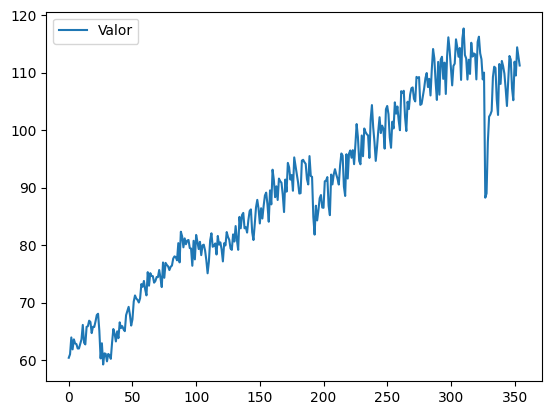

In [4]:
igae.plot();

TRAS GRÁFICA LA INFORMACIÓN PODEMOS VER QUE LOS DATOS TIENE UNA TENDENCIA "NO-SEASONALITY ", YA QUE TIENE UNA TENDENCIA DE CRECIMIENTO EN EL TIEMPO, ADEMÁS TENEMOS QUE COMPROBAR SI SE OBSERVA UN PATRÓN DE ESTACIONALIDAD.

----

PARA ESTAR SEGUROS DE LO QUE MENCIONAMOS ANTERIORMENTE, VAMOS A REALIZAR UN TEST DE ESTACIONALIDAD.

DADO QUE PODEMOS VER UN PATRÓN DE ESTACIONALIDAD EN NUESTROS DATOS, REALIZAMOS LA DIFERENCIA ESTACIONAL DEL LOGARITMO DE LA SERIE, CON ESTO VAMOS A COMPROBAR SI VAMOS A TRATA LA SERIE DE VALORES DE MANERA ESTACIONAL. ADEMÁS GRÁFICAMOS EL COMPORTAMIENTO QUE TIENE EL CRECIMIENTO EN EL ÍNDICE DE VOLUMEN FÍSICO BASE EN MÉXICO.

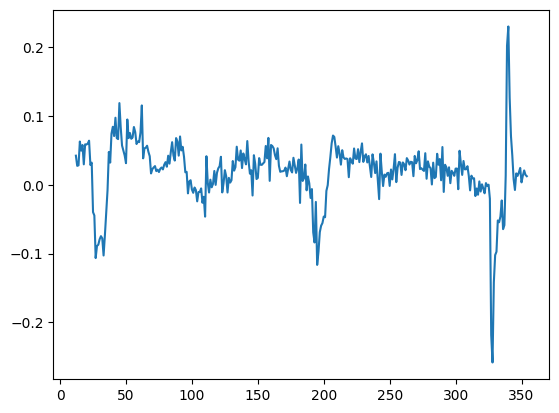

In [5]:
ligae = np.log(igae['Valor']) - np.log(igae['Valor']).shift(12) 
ligae.plot();

ES DIFÍCIL SABER SI LO QUE TENEMOS ES ESTACIONARIO O NO, PARECIERA QUE SI, PERO PARA ESTA SEGUROS PROCEDEREMOS A HACE LA PRUEBA DE DICKY-FULLER.

In [6]:
# Primero dropeamos los na's
ligae = ligae.dropna()

# Creamos una función para generar los outputs
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

# Aplicamos la función para conocer la estacionalidad
dftest = adf_test(ligae)
dftest

Results of Dickey-Fuller Test:
Test Statistic                  -3.767292
p-value                          0.003260
#Lags Used                      17.000000
Number of Observations Used    325.000000
Critical Value (1%)             -3.450632
Critical Value (5%)             -2.870474
Critical Value (10%)            -2.571530
dtype: float64


OBTUVIMOS UN VALOR DE NUESTRO P VALUE MENOR A 0.05, POR LO AHORA TENEMOS LA CERTEZA DE QUE ES UNA SERIE ESTACIONAL Y COMO TAL PODEMOS CALIBRARLA CON UN MODELO ARIMA-SARIMA.

## Calibra un modelo ARIMA-SARIMA basado en pruebas y gráficos de autocorrelaciones

PRIMERO VAMOS A REALIZAR LOS GRÁFICOS DE AUTOCORRELACIONES ACF (AUTOCORRELATION FUNCTION) Y PACF (PARTIAL AUTOCORRELATION FUNCTION) PARA IDENTIFICAR LA RELACIÓN TEMPORAL ENTRE LOS DATOS, Y DE LOS MODELOS AR Y MA QUE SE PUEDEN AGREGAR EN NUESTRO MODELO ARIMA-SARIMA.

CON LO ANTERIOR OBTENEMOS QUE:
- D = 1, PORQUE TRABAJAMOS UNA SERIE ESTACIONAL.
- d = 0, PORQUE VAMOS A CALCULAR EL ANNUAL % CHANGE MONTHLY.

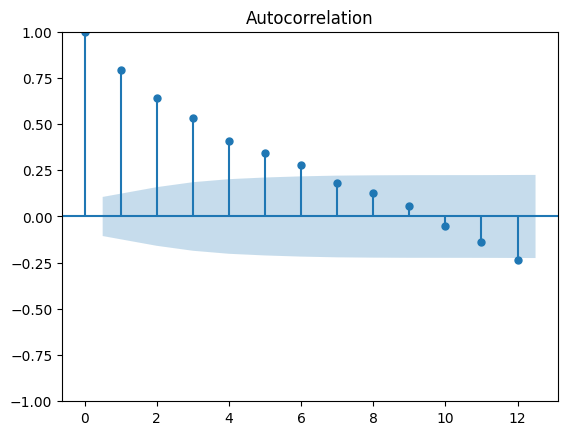

In [7]:
plot_acf(ligae, lags=12);

EN NUESTRO GRÁFICO DE AUTOCORRELACIÓN PODEMOS VER QUE LOS LAGS HASTA EL 6 TIENEN UNA SIGNIFICANCIA POSITVA MAYOR AL 95%.

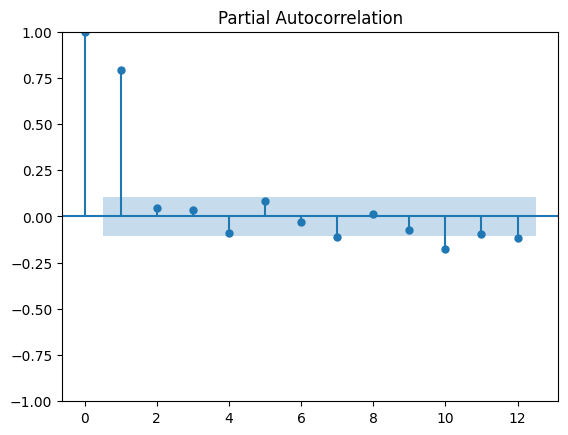

In [8]:
plot_pacf(ligae, lags=12);

EN ESTE GRÁFICO DE AUTOCORRELACIÓN PARCIAL PODEMOS DARNOS CUENTA QUE ÚNICAMENTE EL LAG 1, TIENE UNA AUTOCORRELACIÓN SIGNIFICATIVA.

CON LA INTERPRETACIÓN DE LA GRÁFICAS ACF Y PACF, PODEMOS DETERMINAR QUE EL VALOR QUE VAMOS A ASIGNAR A p (CUANTAS Y VAN A ESTAR EN EL MODELO) Y q (CUANTOS DATOS RANDOM INCONTROLABLES HABRÁ):
- p = 1, PORQUE ENCONTRAMOS QUE SOLO HAY SIGNIFICANCIA ENTRE UN MES CON RESPECTO AL SIGUIENTE.
- q = 0, PORQUE VAMOS A ASUMIR QUE NO EXISTEN.

A CONTINUACIÓN VAMOS A ESTIMAR Y CALIBRAR EL MODELO ARIMA-SARIMA, CON LA INFORMACIÓN OBTENIDA DEL ANÁLISIS DE NUESTROS GRÁFICOS DE AUTOCORRELACIÓN.

In [9]:
# Parameters Arima(p,d,q)
p, d, q = 1, 0, 0

# Parameters Sarima(P,D,Q,#periods in the year)
P, D, Q = 0, 1, 0
periods = 12

y = np.log(igae['Valor'])
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(p,d,q),
                               seasonal_order=(P,D,Q,periods),
                               trend='c',
                               simple_differencing=True
                               )
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         DS12.Valor   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 741.706
Date:                            Fri, 25 Nov 2022   AIC                          -1477.413
Time:                                    14:55:54   BIC                          -1465.899
Sample:                                         0   HQIC                         -1472.827
                                            - 343                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.002      2.741      0.006       0.001       0.007
ar.L1          0.7905      0.021     36.847      0.000       0.748       0.833
sigma2         0.0008   2.09e-05     36.988      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):              3075.60
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Interpretación de coeficientes y su significancia estadística del modelo calibrado

CON LA INFORMACIÓN QUE OBTENEMOS TRAS APLICAR EL MODELO, PODEMOS DECIR QUE EL ÍNDICE GLOBAL DE ACTIVIDAD ECONÓMICA DE MÉXICO ES POSITIVA Y SIGNIFICATIVA CON LA DEL MES ANTERIOR, TENIENDO UN 79%.

EL MODELO REPRESENTADO MATEMÁTICAMENTE NOS DA:<br>
$$ y_{t} = 0.0041 + 0.7905y_{t-1} + 0.0008\sigma$$

AHORA VAMOS A VER COMO SE COMPORTAN LOS RESIDUOS DE NUESTROS DATOS CON GRÁFICOS DE CORRELACIÓN, PARA COMPROBAR SI LA SERIE DE RESIDUOS ES UN RUIDO BLANCO (UNA SERIE QUE NO TIENE AUTOCORRELACIONES SIGNIFICATIVAS CON NINGÚN RETRAZO ANTERIOR).

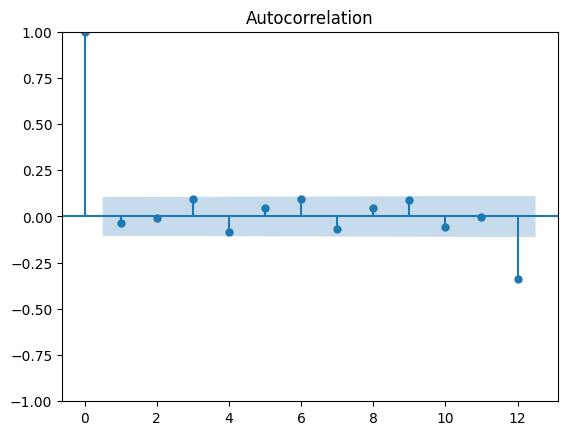

In [10]:
plot_acf(res.resid, lags=12);

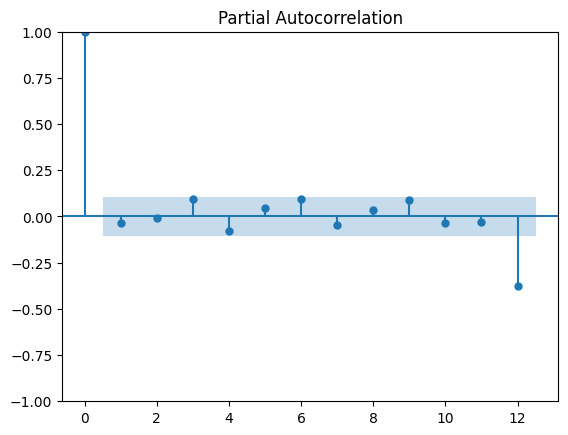

In [11]:
plot_pacf(res.resid, lags=12);

TRAS EL ANÁLISIS NOS PODEMOS PERCATAR DE QUE EN EL ÚLTIMO LAG HAY UNA AUTOCORRELACIÓN SIGNIFICATIVA CON EL MES ANTERIOR, POR LO QUE ES NECESARIO CAMBIAR NUESTRO PARAMETRO Q DE 0 A 1 DEBIDO A QUE EL LAG 12 DECRECE Y SE AGREGA UN TÉRMINO MA Y MEJORAR EL MODELO.

CON LOS ANTERIOR EN MENTE, VAMOS A MEJORAR EL MODELO.

In [12]:
# Parameters Arima(p,d,q)
p, d, q = 1, 0, 0

# Parameters Sarima(P,D,Q,#periods in the year)
P, D, Q = 0, 1, 1
periods = 12

y = np.log(igae['Valor'])
mod2 = sm.tsa.statespace.SARIMAX(y,
                               order=(p,d,q),
                               seasonal_order=(P,D,Q,periods),
                               trend='c',
                               simple_differencing=True
                               )
res2 = mod2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           DS12.Valor   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 805.821
Date:                              Fri, 25 Nov 2022   AIC                          -1603.642
Time:                                      14:56:00   BIC                          -1588.291
Sample:                                           0   HQIC                         -1597.528
                                              - 343                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0025      0.000      6.274      0.000       0.002       0.003
ar.L1          0.8793      0.019     46.540      0.000       0.842       0.916
ma.S.L12      -0.8405      0.047    -17.882      0.000      -0.933      -0.748
sigma2         0.0005   1.33e-05     38.347      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   4.60   Jarque-Bera (JB):              7790.42
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -2.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

REALIZAMOS NUEVAMENTE GRÁFICOS DE AUTOCORRELACIÓN, PARA OBSEVAR EL COMPORTAMIENTO DE LOS NUEVOS RESIDUOS.

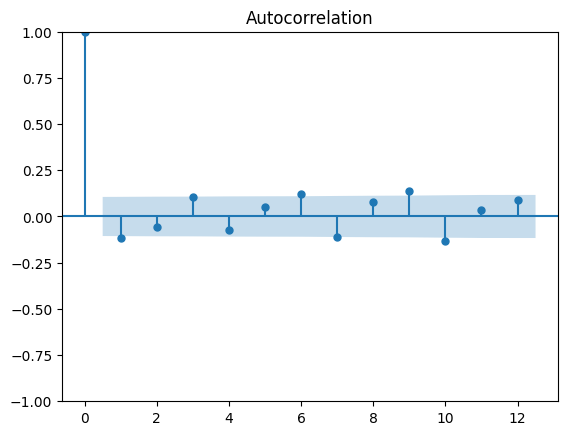

In [13]:
plot_acf(res2.resid, lags = 12);

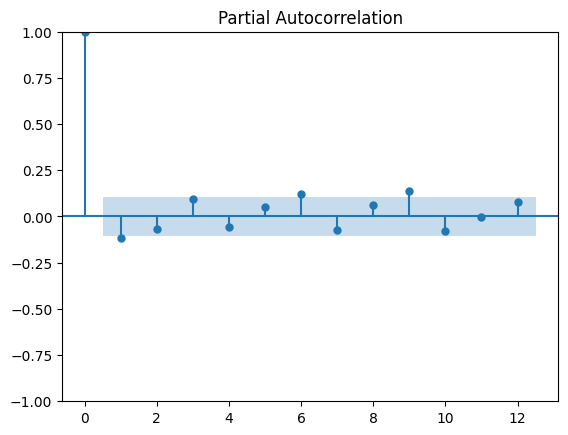

In [14]:
plot_pacf(res2.resid, lags = 12);

VEMOS QUE LOS RESIDUOS MEJORARON CON RESPECTO A LA AUTOCORRELACIÓN QUE TIENEN, SIN EMBARGO SE PUEDE MEJORAR EL MODELO MODIFICANDO P DE 0 A 1, DEBIDO A QUE AGREGANDO UN TÉRMINO AR. Y PODEMOS CAMBIAR q DE 0 A 1 PORQUE LA AUTOCORRELACIÓN CON LAG 1 ES NEGATIVA Y SIGNIFICATIVA. TAMBIÉN PODEMOS LOGRAR QUE EL MES 6 Y 9, QUE TIENEN UNA AUTOCORRELACIÓN  MAYOR A LAS DEMÁS, TENGAN EL COMPORTAMIENTO DE UN RUIDO BLANCO.

APLICAMOS LAS MEJORAS AL NUEVO MODELO.

In [15]:
# Parameters Arima(p,d,q)
p, d, q = 1, 0, 1

# Parameters Sarima(P,D,Q,#periods in the year)
P, D, Q = 1, 1, 1
periods = 12

y = np.log(igae['Valor'])
mod3 = sm.tsa.statespace.SARIMAX(y,
                               order=(p,d,q),
                               seasonal_order=(P,D,Q,periods),
                               trend='c',
                               simple_differencing=True
                               )
res3 = mod3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         DS12.Valor   No. Observations:                  343
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 810.742
Date:                            Fri, 25 Nov 2022   AIC                          -1609.485
Time:                                    14:56:07   BIC                          -1586.458
Sample:                                         0   HQIC                         -1600.313
                                            - 343                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.000      4.347      0.000       0.001       0.003
ar.L1          0.8850      0.026     34.028      0.000       0.834       0.936
ma.L1         -0.1050      0.042     -2.487      0.013      -0.188      -0.022
ar.S.L12       0.1603      0.084      1.909      0.056      -0.004       0.325
ma.S.L12      -0.9032      0.068    -13.284      0.000      -1.036      -0.770
sigma2         0.0005    1.3e-05     37.939      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              9855.93
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                            -2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

INTERPRETACIÓN DE COEFICIENTES:

EL ÍNDICE GLOBAL DE ACTIVIDAD ECONÓMICA DE MÉXICO

- intercept
- ar.L1 
- ma.L1
- ar.S.L12
- ma.S.L12
- sigma2

HACEMOS NUEVAMENTE LOS GRÁFICOS DE AUTOCORRELACIÓN.

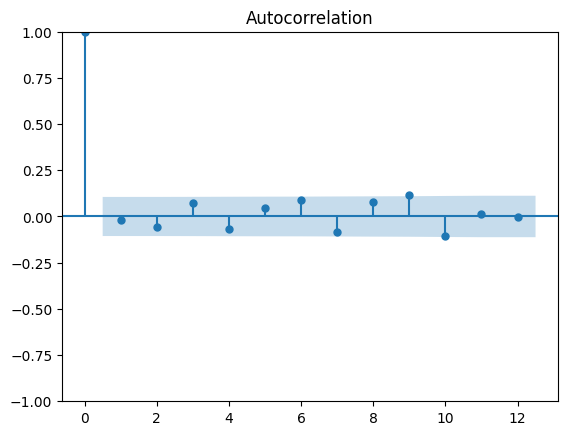

In [16]:
plot_acf(res3.resid, lags = 12);

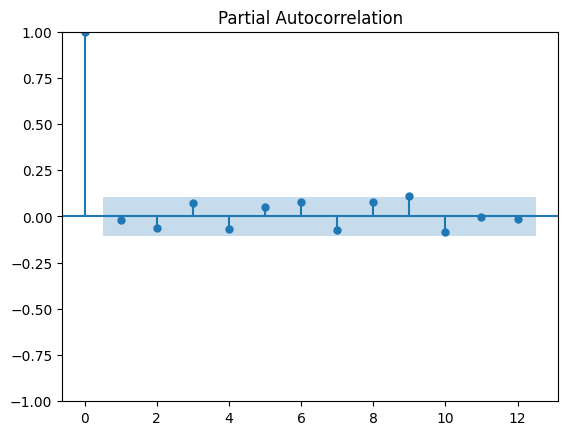

In [17]:
plot_pacf(res3.resid, lags = 12);

AHORA VEMOS QUE LOS RESIDUOS SE COMPORTAN MÁS COMO UN RUIDO BLANCO, POR LO QUE EL MODELO ACTUAL FUNCIONARIA DE UNA MEJOR MANERA QUE LOS ANTERIORES 2.

## Predicción de la variable con el modelo calibrado

In [28]:
y = np.log(igae['Valor'])
y_pred = 0.0020 + 0.8850*igae['Valor'].shift(1) + 0.1603*igae['Valor'].shift(1) - 0.9032*(-0.5/0.9032)
igae['Pred'] = y_pred

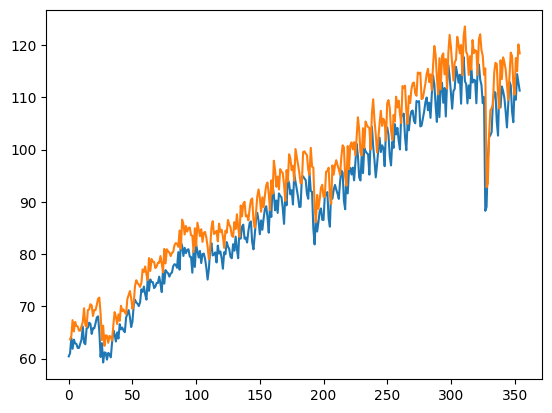

In [29]:
plt.plot(igae['Valor']);
plt.plot(igae['Pred']);

COMO PODEMOS VER EN EL GRÁFICO, NUESTRO MODELO DE PREDICCIÓN FUNCIONA DE MUY BIEN, YA QUE TIENE UN COMPPORTAMIENTO MUY SIMILAR A EL DE NUESTROS DATOS ORIGINALES. AHORA VAMOS A PREDECIR EL ÍNDICE GLOBAL DE LA ACTIVIDAD ECONÓMICA EN MÉXICO UN MES EN EL FUTURO.

In [30]:
y_pred = 0.0020+ 0.8850*igae['Valor'][len(igae)-1] + 0.1603*igae['Valor'][len(igae)-1] - 0.9032*(-0.5/0.9032)
y_pred

116.81728903030319